In [1]:
import dynpssimpy.dynamic as dps
import dynpssimpy.modal_analysis as dps_mdl
import dynpssimpy.plotting as dps_plt
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
with open('k2a.json') as f:
    data= f.read()

In [3]:
model = json.loads(data)

In [4]:
def change_gen_power(model, powers):
    for i, power in enumerate(powers):
        model["generators"]["GEN"][i+1][4] = power
    return dps.PowerSystemModel(model=model)

In [5]:
def get_gen_power_vector(model):
    return np.array([gen[4] for gen in model["generators"]["GEN"][1:]])

In [6]:
def get_machine_ratings(model):
    return np.array([gen[2] for gen in model["generators"]["GEN"][1:]])

In [7]:
def get_gen_names(model):
    return [gen[0] for gen in model["generators"]["GEN"][1:]]

In [8]:
def reschedule_and_get_min_damping(model, powers):
    ps = change_gen_power(model, powers)
    ps.init_dyn_sim()
    ps_lin = dps_mdl.PowerSystemModelLinearization(ps)
    ps_lin.linearize()
    ps_lin.eigenvalue_decomposition()
    return min(ps_lin.damping)

In [9]:
def get_random_dispatch(model):
    old_powers = get_gen_power_vector(model)
    new_powers = [np.random.normal(power, power*0.01) for power in old_powers]
    slack = sum(old_powers) - sum(new_powers)
    ratings = get_machine_ratings(model)
    total_rating = sum(ratings)
    new_powers += slack*ratings/total_rating # I should consider generator ratings later
    return new_powers

In [10]:
def generate_priors(model, N_priors):
    gen_names = get_gen_names(model)
    df = pd.DataFrame(0, range(0, N_priors), ["damping"]+gen_names)
    for idx, row in df.iterrows():
        power = get_random_dispatch(model)
        df.loc[idx, gen_names] = power
        df.loc[idx, "damping"] = reschedule_and_get_min_damping(model, power)
    return df

In [11]:
df = generate_priors(model, 100)

Standard model: lines, Line
Standard model: loads, Load
Standard model: shunts, Shunt
Standard model: gov, TGOV1
Standard model: avr, SEXS
Standard model: pss, STAB1
Standard model: trafos, Trafo
Standard model: gen, GEN
Standard model: lines, Line
Standard model: loads, Load
Standard model: shunts, Shunt
Standard model: gov, TGOV1
Standard model: avr, SEXS
Standard model: pss, STAB1
Standard model: trafos, Trafo
Standard model: gen, GEN
Standard model: lines, Line
Standard model: loads, Load
Standard model: shunts, Shunt
Standard model: gov, TGOV1
Standard model: avr, SEXS
Standard model: pss, STAB1
Standard model: trafos, Trafo
Standard model: gen, GEN
Standard model: lines, Line
Standard model: loads, Load
Standard model: shunts, Shunt
Standard model: gov, TGOV1
Standard model: avr, SEXS
Standard model: pss, STAB1
Standard model: trafos, Trafo
Standard model: gen, GEN
Standard model: lines, Line
Standard model: loads, Load
Standard model: shunts, Shunt
Standard model: gov, TGOV1
Sta

In [16]:
df.damping

0    -1.000000
1     0.097242
2    -1.000000
3    -1.000000
4    -1.000000
        ...   
95   -1.000000
96    0.096242
97    0.095528
98    0.094481
99   -1.000000
Name: damping, Length: 100, dtype: float64

<AxesSubplot: >

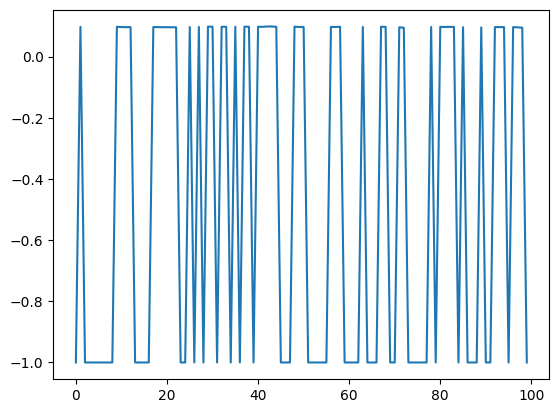

In [14]:
df["damping"].plot()

In [15]:
dps_plt.plot_eigs(ps_lin.eigs)

NameError: name 'ps_lin' is not defined

In [ ]:
mode_idx = ps_lin.get_mode_idx(['em'], damp_threshold=0.3)
rev = ps_lin.rev
mode_shape = rev[np.ix_(ps.gen['GEN'].state_idx_global['speed'], mode_idx)]

# Plot mode shape
fig, ax = plt.subplots(1, mode_shape.shape[1], subplot_kw={'projection': 'polar'})
for ax_, ms in zip(ax, mode_shape.T):
    dps_plt.plot_mode_shape(ms, ax=ax_, normalize=True)

plt.show()

In [ ]:
min(ps_lin.damping)

In [ ]:
ps_lin.damping